Epoch 1/80


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0458
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0165
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0131
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0112
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0103
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0095
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0088
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0081
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0078
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0073
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0070
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0067
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0066
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0068
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0061
Epoch 16/80
85/

Model saved as 'sharpe_ratio_predictor_model.h5'
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Suggested top 4 stocks to invest in: DIVISLAB.NS, BAJFINANCE.NS, BAJAJFINSV.NS, MARUTI.NS
Each stock will receive an investment of: $25000.00


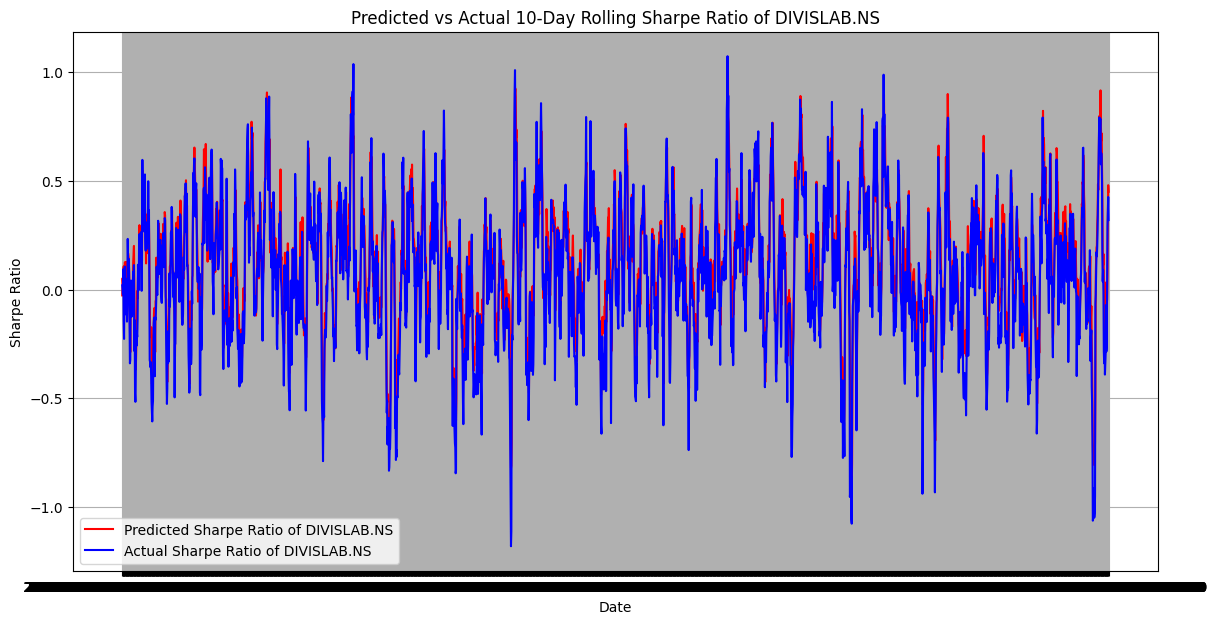

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    # Load the saved Sharpe Ratio data
    sharpe_data = pd.read_csv(file_path, index_col=0)
    
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(sharpe_data.fillna(0))
    
    return sharpe_data, scaled_data, scaler

def prepare_data_for_lstm(scaled_data, window_size=10):
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i])
        y.append(scaled_data[i])
    
    X, y = np.array(X), np.array(y)
    return X, y

def build_and_train_model(X, y):
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1]))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X, y, epochs=80, batch_size=32)
    
    return model

def make_predictions(model, X, scaler):
    # Make predictions
    predicted_sharpe = model.predict(X)

    # Inverse transform to get actual values
    predicted_sharpe_actual = scaler.inverse_transform(predicted_sharpe)
    
    return predicted_sharpe_actual

def suggest_best_stocks(predicted_sharpe_actual, sharpe_data, tickers, budget=100000, investment_period=365):
    # Get the top 4 stocks with the highest predicted Sharpe Ratios
    avg_predicted_sharpe = np.mean(predicted_sharpe_actual, axis=0)
    top_4_stocks_indices = np.argsort(avg_predicted_sharpe)[-4:]
    top_4_stocks = [tickers[i] for i in top_4_stocks_indices]
    
    print(f"Suggested top 4 stocks to invest in: {', '.join(top_4_stocks)}")
    
    # Example allocation: equally distributed investment
    allocation_per_stock = budget / len(top_4_stocks)
    print(f"Each stock will receive an investment of: ${allocation_per_stock:.2f}")
    
    return top_4_stocks, allocation_per_stock

def main():
    # Load data and preprocess
    file_path = 'indian_stocks_rolling_sharpe_ratios.csv'
    sharpe_data, scaled_data, scaler = load_and_preprocess_data(file_path)
    
    # Prepare data for LSTM model
    X, y = prepare_data_for_lstm(scaled_data)
    
    # Build and train the model
    model = build_and_train_model(X, y)
    
    # Save the model
    model.save('sharpe_ratio_predictor_model.h5')
    print("Model saved as 'sharpe_ratio_predictor_model.h5'")
    
    # Make predictions
    predicted_sharpe_actual = make_predictions(model, X, scaler)
    
    # Define tickers based on column names
    tickers = sharpe_data.columns.tolist()
    
    # Suggest the best stocks to invest in
    top_4_stocks, allocation_per_stock = suggest_best_stocks(predicted_sharpe_actual, sharpe_data, tickers)
    
    # Plotting example for the first suggested stock (Optional)
    plt.figure(figsize=(14, 7))
    plt.plot(sharpe_data.index[10:], predicted_sharpe_actual[:, tickers.index(top_4_stocks[0])], label=f'Predicted Sharpe Ratio of {top_4_stocks[0]}', color='red')
    plt.plot(sharpe_data.index[10:], sharpe_data[top_4_stocks[0]].values[10:], label=f'Actual Sharpe Ratio of {top_4_stocks[0]}', color='blue')
    plt.title(f'Predicted vs Actual 10-Day Rolling Sharpe Ratio of {top_4_stocks[0]}')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()



In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the saved model
model = load_model('sharpe_ratio_predictor_model.h5')

# Load and preprocess the data again
file_path = 'indian_stocks_rolling_sharpe_ratios.csv'
sharpe_data = pd.read_csv(file_path, index_col=0)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sharpe_data.fillna(0))

# Prepare data for LSTM
window_size = 10
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

In [83]:
# Make predictions
predicted_sharpe = model.predict(X)

# Inverse transform both predicted and actual values
predicted_sharpe_actual = scaler.inverse_transform(predicted_sharpe)
actual_sharpe_actual = scaler.inverse_transform(y)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


In [84]:
# RMSE
mse = mean_squared_error(actual_sharpe_actual, predicted_sharpe_actual)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# R-squared
r2 = r2_score(actual_sharpe_actual, predicted_sharpe_actual)
print(f"R-squared: {r2:.4f}")


Root Mean Squared Error (RMSE): 1.6022
R-squared: 0.8032


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Investment Strategy Summary:
                       Stock  Investment_Amount  Weight  Predicted_Sharpe  Expected_Return  Volatility
BAJFINANCE.NS  BAJFINANCE.NS          111469.35   11.15          0.133249         0.102073    0.347624
BAJAJFINSV.NS  BAJAJFINSV.NS          103106.91   10.31          0.143314         0.074898    0.345774
TITAN.NS            TITAN.NS          100681.15   10.07          0.110911         0.076730    0.329870
HCLTECH.NS        HCLTECH.NS          100153.75   10.02          0.079936         0.083595    0.311238
MARUTI.NS          MARUTI.NS           99353.15    9.94          0.143685         0.063943    0.347421
DIVISLAB.NS      DIVISLAB.NS           97368.69    9.74          0.128389         0.061856    0.318187
INDUSINDBK.NS  INDUSINDBK.NS           97048.11    9.70          0.093509         0.071105    0.327728
BRITANNIA.NS    BRITANNIA.NS           97042.90    9.70          0.068844         0.079028    0.365597
JSW

/var/folders/4y/p5wbs2392ng1qdh47g8kk6x00000gn/T/ipykernel_36099/4097116744.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = combined_score[top_indices]
/var/folders/4y/p5wbs2392ng1qdh47g8kk6x00000gn/T/ipykernel_36099/4097116744.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Expected_Return': [returns[i] for i in top_indices],
/var/folders/4y/p5wbs2392ng1qdh47g8kk6x00000gn/T/ipykernel_36099/4097116744.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

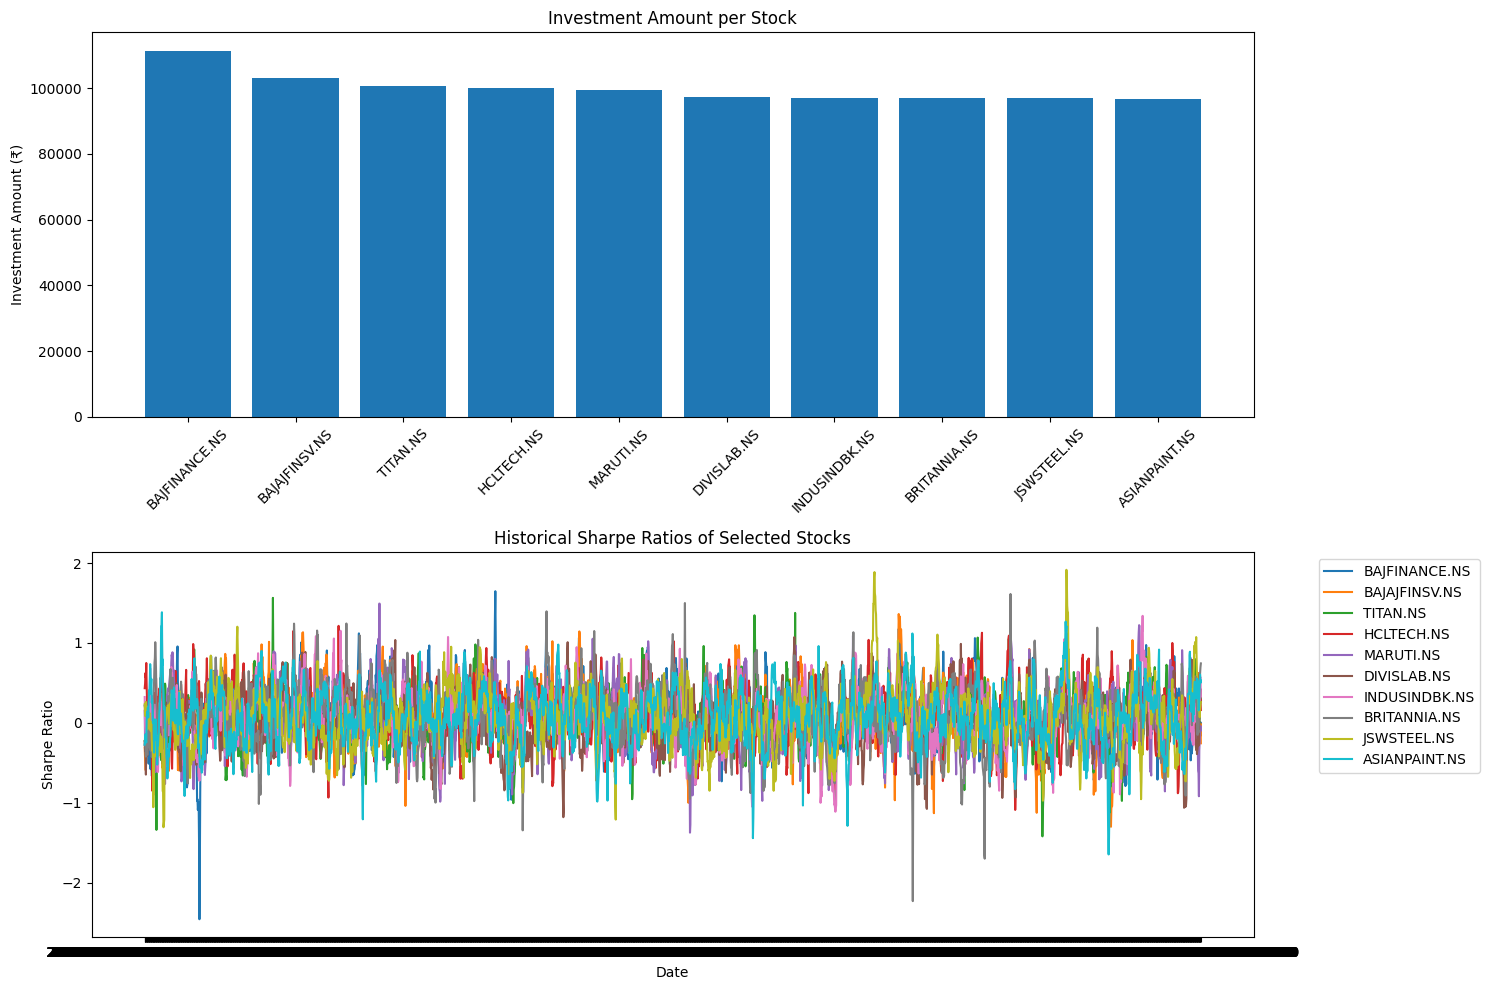

In [85]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime

def load_and_prepare_data(file_path, start_date='2023-01-01', end_date='2024-01-31'):
    # Load the saved Sharpe Ratio data
    sharpe_data = pd.read_csv(file_path, index_col=0)
    sharpe_data.index = pd.to_datetime(sharpe_data.index)
    
    # Filter data for the specified date range
    mask = (sharpe_data.index >= start_date) & (sharpe_data.index <= end_date)
    filtered_data = sharpe_data.loc[mask]
    
    return filtered_data

def analyze_investment_strategy(predicted_sharpe_actual, sharpe_data, tickers, 
                             budget=1000000, num_stocks=10, 
                             start_date='2023-01-01', end_date='2024-01-31'):
    # Calculate average predicted Sharpe ratio for the period
    avg_predicted_sharpe = np.mean(predicted_sharpe_actual, axis=0)
    
    # Get volatility and returns for risk-adjusted allocation
    volatility = sharpe_data.std()
    returns = sharpe_data.mean()
    
    # Create a score combining Sharpe ratio, volatility, and returns
    normalized_sharpe = (avg_predicted_sharpe - min(avg_predicted_sharpe)) / (max(avg_predicted_sharpe) - min(avg_predicted_sharpe))
    normalized_vol = (volatility - min(volatility)) / (max(volatility) - min(volatility))
    normalized_returns = (returns - min(returns)) / (max(returns) - min(returns))
    
    # Combined score (higher is better)
    combined_score = normalized_sharpe + normalized_returns - normalized_vol
    
    # Get top stocks based on combined score
    top_indices = np.argsort(combined_score)[-num_stocks:]
    selected_stocks = [tickers[i] for i in top_indices]
    
    # Calculate weights based on the combined score
    weights = combined_score[top_indices]
    weights = weights / np.sum(weights)  # Normalize to sum to 1
    
    # Calculate investment amounts
    investments = weights * budget
    
    # Create investment summary
    investment_summary = pd.DataFrame({
        'Stock': selected_stocks,
        'Investment_Amount': investments,
        'Weight': weights,
        'Predicted_Sharpe': [avg_predicted_sharpe[i] for i in top_indices],
        'Expected_Return': [returns[i] for i in top_indices],
        'Volatility': [volatility[i] for i in top_indices]
    })
    
    investment_summary = investment_summary.sort_values('Investment_Amount', ascending=False)
    investment_summary['Investment_Amount'] = investment_summary['Investment_Amount'].round(2)
    investment_summary['Weight'] = (investment_summary['Weight'] * 100).round(2)
    
    return investment_summary

def plot_investment_strategy(investment_summary, sharpe_data, start_date, end_date):
    plt.figure(figsize=(15, 10))
    
    # Create bar plot of investment amounts
    plt.subplot(2, 1, 1)
    plt.bar(investment_summary['Stock'], investment_summary['Investment_Amount'])
    plt.title('Investment Amount per Stock')
    plt.xticks(rotation=45)
    plt.ylabel('Investment Amount (₹)')
    
    # Create line plot of historical Sharpe ratios for selected stocks
    plt.subplot(2, 1, 2)
    for stock in investment_summary['Stock']:
        plt.plot(sharpe_data.index, sharpe_data[stock], label=stock)
    plt.title('Historical Sharpe Ratios of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    # Parameters
    file_path = 'indian_stocks_rolling_sharpe_ratios.csv'
    model_path = 'sharpe_ratio_predictor_model.h5'
    start_date = '2023-01-01'
    end_date = '2024-01-31'
    budget = 1000000
    num_stocks = 10
    
    # Load the saved model
    model = load_model(model_path)
    
    # Load and preprocess data
    sharpe_data, scaled_data, scaler = load_and_preprocess_data(file_path)
    
    # Prepare data for LSTM (like during training)
    X, _ = prepare_data_for_lstm(scaled_data)  # We don't need `y` here, just `X`
    
    # Make predictions using the model
    predicted_sharpe_actual = make_predictions(model, X, scaler)
    
    # Get tickers (column names of the data)
    tickers = sharpe_data.columns.tolist()
    
    # Analyze investment strategy
    investment_summary = analyze_investment_strategy(
        predicted_sharpe_actual, 
        sharpe_data, 
        tickers, 
        budget=budget,
        num_stocks=num_stocks,
        start_date=start_date,
        end_date=end_date
    )
    
    # Print investment summary
    print("\nInvestment Strategy Summary:")
    print("============================")
    print(investment_summary.to_string())
    
    # Plot the results
    plot_investment_strategy(investment_summary, sharpe_data, start_date, end_date)

if __name__ == '__main__':
    main()


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Investment Strategy Summary:
                       Stock  Investment_Amount  Weight  Predicted_Sharpe  Expected_Return  Volatility
BAJFINANCE.NS  BAJFINANCE.NS           58359.92    5.84          0.133249         0.102073    0.347624
BAJAJFINSV.NS  BAJAJFINSV.NS           53981.76    5.40          0.143314         0.074898    0.345774
TITAN.NS            TITAN.NS           52711.75    5.27          0.110911         0.076730    0.329870
HCLTECH.NS        HCLTECH.NS           52435.63    5.24          0.079936         0.083595    0.311238
MARUTI.NS          MARUTI.NS           52016.47    5.20          0.143685         0.063943    0.347421
DIVISLAB.NS      DIVISLAB.NS           50977.50    5.10          0.128389         0.061856    0.318187
INDUSINDBK.NS  INDUSINDBK.NS           50809.66    5.08          0.093509         0.071105    0.327728
BRITANNIA.NS    BRITANNIA.NS           50806.94    5.08          0.068844         0.079028    0.365597
JSW

/var/folders/4y/p5wbs2392ng1qdh47g8kk6x00000gn/T/ipykernel_36099/181277108.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = combined_score[top_indices]
/var/folders/4y/p5wbs2392ng1qdh47g8kk6x00000gn/T/ipykernel_36099/181277108.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Expected_Return': [returns[i] for i in top_indices],
/var/folders/4y/p5wbs2392ng1qdh47g8kk6x00000gn/T/ipykernel_36099/181277108.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

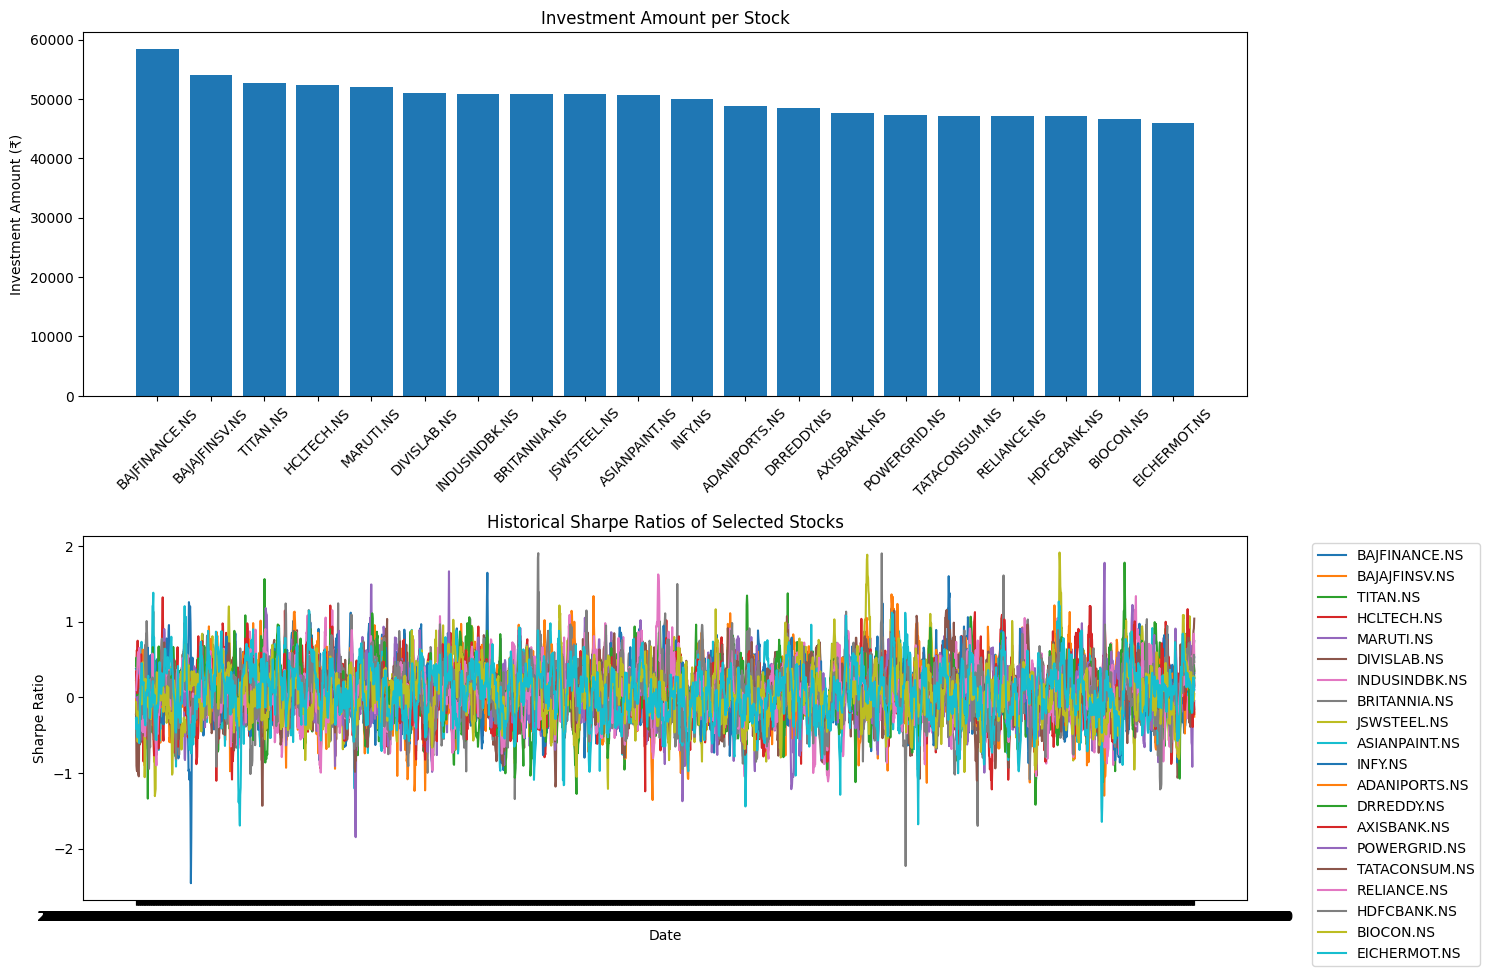

In [86]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime

def load_and_prepare_data(file_path, start_date='2023-01-01', end_date='2025-01-31'):
    # Load the saved Sharpe Ratio data
    sharpe_data = pd.read_csv(file_path, index_col=0)
    sharpe_data.index = pd.to_datetime(sharpe_data.index)
    
    # Filter data for the specified date range
    mask = (sharpe_data.index >= start_date) & (sharpe_data.index <= end_date)
    filtered_data = sharpe_data.loc[mask]
    
    return filtered_data

def analyze_investment_strategy(predicted_sharpe_actual, sharpe_data, tickers, 
                             budget=1000000, num_stocks=20, 
                             start_date='2023-01-01', end_date='2025-01-31'):
    # Calculate average predicted Sharpe ratio for the period
    avg_predicted_sharpe = np.mean(predicted_sharpe_actual, axis=0)
    
    # Get volatility and returns for risk-adjusted allocation
    volatility = sharpe_data.std()
    returns = sharpe_data.mean()
    
    # Create a score combining Sharpe ratio, volatility, and returns
    normalized_sharpe = (avg_predicted_sharpe - min(avg_predicted_sharpe)) / (max(avg_predicted_sharpe) - min(avg_predicted_sharpe))
    normalized_vol = (volatility - min(volatility)) / (max(volatility) - min(volatility))
    normalized_returns = (returns - min(returns)) / (max(returns) - min(returns))
    
    # Combined score (higher is better)
    combined_score = normalized_sharpe + normalized_returns - normalized_vol
    
    # Get top stocks based on combined score
    top_indices = np.argsort(combined_score)[-num_stocks:]
    selected_stocks = [tickers[i] for i in top_indices]
    
    # Calculate weights based on the combined score
    weights = combined_score[top_indices]
    weights = weights / np.sum(weights)  # Normalize to sum to 1
    
    # Calculate investment amounts
    investments = weights * budget
    
    # Create investment summary
    investment_summary = pd.DataFrame({
        'Stock': selected_stocks,
        'Investment_Amount': investments,
        'Weight': weights,
        'Predicted_Sharpe': [avg_predicted_sharpe[i] for i in top_indices],
        'Expected_Return': [returns[i] for i in top_indices],
        'Volatility': [volatility[i] for i in top_indices]
    })
    
    investment_summary = investment_summary.sort_values('Investment_Amount', ascending=False)
    investment_summary['Investment_Amount'] = investment_summary['Investment_Amount'].round(2)
    investment_summary['Weight'] = (investment_summary['Weight'] * 100).round(2)
    
    return investment_summary

def plot_investment_strategy(investment_summary, sharpe_data, start_date, end_date):
    plt.figure(figsize=(15, 10))
    
    # Create bar plot of investment amounts
    plt.subplot(2, 1, 1)
    plt.bar(investment_summary['Stock'], investment_summary['Investment_Amount'])
    plt.title('Investment Amount per Stock')
    plt.xticks(rotation=45)
    plt.ylabel('Investment Amount (₹)')
    
    # Create line plot of historical Sharpe ratios for selected stocks
    plt.subplot(2, 1, 2)
    for stock in investment_summary['Stock']:
        plt.plot(sharpe_data.index, sharpe_data[stock], label=stock)
    plt.title('Historical Sharpe Ratios of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    # Parameters
    file_path = 'indian_stocks_rolling_sharpe_ratios.csv'
    model_path = 'sharpe_ratio_predictor_model.h5'
    start_date = '2023-01-01'
    end_date = '2025-01-31'
    budget = 1000000
    num_stocks = 20
    
    # Load the saved model
    model = load_model(model_path)
    
    # Load and preprocess data
    sharpe_data, scaled_data, scaler = load_and_preprocess_data(file_path)
    
    # Prepare data for LSTM (like during training)
    X, _ = prepare_data_for_lstm(scaled_data)  # We don't need `y` here, just `X`
    
    # Make predictions using the model
    predicted_sharpe_actual = make_predictions(model, X, scaler)
    
    # Get tickers (column names of the data)
    tickers = sharpe_data.columns.tolist()
    
    # Analyze investment strategy
    investment_summary = analyze_investment_strategy(
        predicted_sharpe_actual, 
        sharpe_data, 
        tickers, 
        budget=budget,
        num_stocks=num_stocks,
        start_date=start_date,
        end_date=end_date
    )
    
    # Print investment summary
    print("\nInvestment Strategy Summary:")
    print("============================")
    print(investment_summary.to_string())
    
    # Plot the results
    plot_investment_strategy(investment_summary, sharpe_data, start_date, end_date)

if __name__ == '__main__':
    main()



Investment Performance Analysis (Jan 2023 - Jan 2024)

Total Return: ₹216,335.53
Return Percentage: 21.63%
Maximum Drawdown: -9.97%
Portfolio Volatility: 10.26%

Individual Stock Performance:
--------------------------------------------------
BAJFINANCE.NS:
  Initial Investment: ₹58,359.92
  Return: ₹2,603.93
  Return %: 4.46%

BAJAJFINSV.NS:
  Initial Investment: ₹53,981.76
  Return: ₹1,352.18
  Return %: 2.50%

TITAN.NS:
  Initial Investment: ₹52,711.75
  Return: ₹24,548.46
  Return %: 46.57%

HCLTECH.NS:
  Initial Investment: ₹52,435.63
  Return: ₹30,401.30
  Return %: 57.98%

MARUTI.NS:
  Initial Investment: ₹52,016.47
  Return: ₹10,163.99
  Return %: 19.54%

DIVISLAB.NS:
  Initial Investment: ₹50,977.50
  Return: ₹3,577.67
  Return %: 7.02%

INDUSINDBK.NS:
  Initial Investment: ₹50,809.66
  Return: ₹12,853.08
  Return %: 25.30%

BRITANNIA.NS:
  Initial Investment: ₹50,806.94
  Return: ₹10,498.42
  Return %: 20.66%

JSWSTEEL.NS:
  Initial Investment: ₹50,782.50
  Return: ₹2,627.89

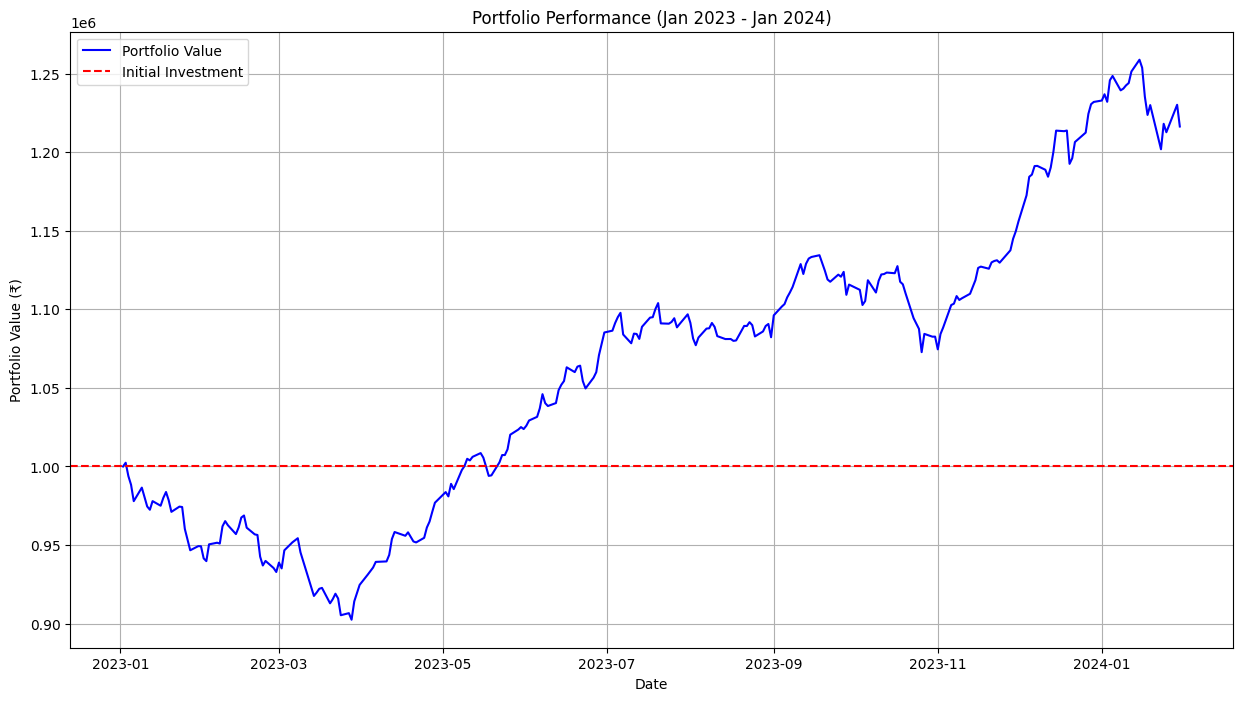

In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def get_stock_data(tickers, start_date, end_date):
    portfolio_data = pd.DataFrame()
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        portfolio_data[ticker] = hist['Close']
    
    return portfolio_data

def calculate_returns(portfolio_data, investment_amounts):
    # Calculate percentage changes from start to end
    start_prices = portfolio_data.iloc[0]
    end_prices = portfolio_data.iloc[-1]
    price_returns = (end_prices - start_prices) / start_prices
    
    # Calculate absolute returns for each stock
    absolute_returns = {}
    for ticker in portfolio_data.columns:
        initial_investment = investment_amounts[ticker]
        returns = initial_investment * (1 + price_returns[ticker])
        absolute_returns[ticker] = returns - initial_investment
    
    return absolute_returns, price_returns

def analyze_performance(portfolio_data, investment_amounts):
    # Initial investment
    total_investment = sum(investment_amounts.values())
    
    # Calculate daily portfolio value
    daily_values = pd.DataFrame()
    
    for ticker in portfolio_data.columns:
        initial_shares = investment_amounts[ticker] / portfolio_data[ticker].iloc[0]
        daily_values[ticker] = portfolio_data[ticker] * initial_shares
    
    portfolio_value = daily_values.sum(axis=1)
    
    # Calculate metrics
    total_return = (portfolio_value.iloc[-1] - total_investment)
    return_percentage = (total_return / total_investment) * 100
    
    # Calculate max drawdown
    rolling_max = portfolio_value.expanding().max()
    daily_drawdown = portfolio_value / rolling_max - 1
    max_drawdown = min(daily_drawdown) * 100
    
    # Calculate volatility
    daily_returns = portfolio_value.pct_change()
    volatility = daily_returns.std() * np.sqrt(252) * 100  # Annualized
    
    return {
        'total_return': total_return,
        'return_percentage': return_percentage,
        'max_drawdown': max_drawdown,
        'volatility': volatility,
        'daily_values': portfolio_value
    }

def plot_portfolio_performance(portfolio_value, start_date, end_date):
    plt.figure(figsize=(15, 8))
    plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value', color='blue')
    plt.axhline(y=1000000, color='r', linestyle='--', label='Initial Investment')
    plt.title('Portfolio Performance (Jan 2023 - Jan 2024)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main analysis
start_date = '2023-01-01'
end_date = '2024-01-31'

# Investment amounts from your strategy
investment_amounts = {
    "BAJFINANCE.NS": 58359.92,
    "BAJAJFINSV.NS": 53981.76,
    "TITAN.NS": 52711.75,
    "HCLTECH.NS": 52435.63,
    "MARUTI.NS": 52016.47,
    "DIVISLAB.NS": 50977.50,
    "INDUSINDBK.NS": 50809.66,
    "BRITANNIA.NS": 50806.94,
    "JSWSTEEL.NS": 50782.50,
    "ASIANPAINT.NS": 50669.18,
    "INFY.NS": 49996.27,
    "ADANIPORTS.NS": 48820.13,
    "DRREDDY.NS": 48537.18,
    "AXISBANK.NS": 47639.71,
    "POWERGRID.NS": 47241.23,
    "TATACONSUM.NS": 47212.12,
    "RELIANCE.NS": 47195.06,
    "HDFCBANK.NS": 47186.15,
    "BIOCON.NS": 46627.69,
    "EICHERMOT.NS": 45993.16
}

# Get historical data
portfolio_data = get_stock_data(investment_amounts.keys(), start_date, end_date)

# Calculate individual stock returns
absolute_returns, price_returns = calculate_returns(portfolio_data, investment_amounts)

# Calculate overall portfolio performance
performance = analyze_performance(portfolio_data, investment_amounts)

# Print results
print("\nInvestment Performance Analysis (Jan 2023 - Jan 2024)")
print("=" * 50)
print(f"\nTotal Return: ₹{performance['total_return']:,.2f}")
print(f"Return Percentage: {performance['return_percentage']:.2f}%")
print(f"Maximum Drawdown: {performance['max_drawdown']:.2f}%")
print(f"Portfolio Volatility: {performance['volatility']:.2f}%")

print("\nIndividual Stock Performance:")
print("-" * 50)
for ticker in investment_amounts.keys():
    print(f"{ticker}:")
    print(f"  Initial Investment: ₹{investment_amounts[ticker]:,.2f}")
    print(f"  Return: ₹{absolute_returns[ticker]:,.2f}")
    print(f"  Return %: {price_returns[ticker]*100:.2f}%")
    print()

# Plot portfolio performance
plot_portfolio_performance(performance['daily_values'], start_date, end_date)